# Import Modules

In [2]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import h5py 
import ray
import logging 
import json
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import io_dict_to_hdf5 as ioh5
import xarray as xr
import scipy.linalg as linalg
import scipy.sparse as sparse
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm, trange
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
from scipy.ndimage import shift as imshift
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import linear_model as lm 
from scipy.stats import binned_statistic
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_poisson_deviance
from numpy.lib.stride_tricks import sliding_window_view

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision
from scipy.ndimage import uniform_filter1d 
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute().parent))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import load_ephys_data_aligned

pd.set_option('display.max_rows', None)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Decoding')

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)
# print(f'Dashboard URL: http://{ray.get_dashboard_url()}')
# print('Dashboard URL: http://localhost:{}'.format(ray.get_dashboard_url().split(':')[-1]))

{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:22607',
 'object_store_address': '/tmp/ray/session_2021-10-13_10-26-43_032713_370742/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-13_10-26-43_032713_370742/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-10-13_10-26-43_032713_370742',
 'metrics_export_port': 55432,
 'node_id': '6fa86f8d44a130b41ebd0c1b33df1cb279bbbe67c43489a5bf7a947a'}

Decode out spatial patches from neural activity. 

nonlinear combining of visual and movement gives more predictive power then linear combining. 

frames and movement at time t predict visual info at t+1 with linear comb and nonlinear comb. combining in nonlin way would work better. 

how to make linear or nonlinear combinations of inputs? input is pixel intensities, and movment params output pixel intesities at t+1. 

mult case: random projection at same dimentionality. Pixels * movement. 

h0 just visual predicts only visual. movement "adds" something here. 

# Gather Data

In [3]:
def load_train_test(file_dict, save_dir, model_dt=.1, frac=.1, train_size=.7, do_shuffle=False, do_norm=False, free_move=True, has_imu=True, has_mouse=False,):
    ##### Load in preprocessed data #####
    data = load_ephys_data_aligned(file_dict, save_dir, model_dt=model_dt, free_move=free_move, has_imu=has_imu, has_mouse=has_mouse,)
    if free_move:
        ##### Find 'good' timepoints when mouse is active #####
        nan_idxs = []
        for key in data.keys():
            nan_idxs.append(np.where(np.isnan(data[key]))[0])
        good_idxs = np.ones(len(data['model_active']),dtype=bool)
        good_idxs[data['model_active']<.5] = False
        good_idxs[np.unique(np.hstack(nan_idxs))] = False
    else:
        good_idxs = np.where((np.abs(data['model_th'])<10) & (np.abs(data['model_phi'])<10))[0]
    
    data['raw_nsp'] = data['model_nsp'].copy()
    ##### return only active data #####
    for key in data.keys():
        if (key != 'model_nsp') & (key != 'model_active') & (key != 'unit_nums'):
            data[key] = data[key][good_idxs] # interp_nans(data[key]).astype(float)
        elif (key == 'model_nsp'):
            data[key] = data[key][good_idxs]
        elif (key == 'unit_nums'):
            pass
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
    nT = data['model_nsp'].shape[0]
    groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])

    for train_idx, test_idx in gss.split(np.arange(len(data['model_nsp'])), groups=groups):
        print("TRAIN:", len(train_idx), "TEST:", len(test_idx))


    data['model_dth'] = np.diff(data['model_th'],append=0)
    data['model_dphi'] = np.diff(data['model_phi'],append=0)

    data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)
    data['model_vid_sm'][np.isnan(data['model_vid_sm'])]=0
    if do_norm:
#         data['model_vid_sm'] = (data['model_vid_sm'])/np.max(data['model_vid_sm'],axis=(-1,-2))[:,np.newaxis,np.newaxis]
        data['model_th'] = (data['model_th'] - np.mean(data['model_th'],axis=0))/np.std(data['model_th'],axis=0) 
        data['model_phi'] = (data['model_phi'] - np.mean(data['model_phi'],axis=0))/np.std(data['model_phi'],axis=0) 
        if free_move:
            data['model_roll'] = (data['model_roll'] - np.mean(data['model_roll'],axis=0))/np.std(data['model_roll'],axis=0) 
            data['model_pitch'] = (data['model_pitch'] - np.mean(data['model_pitch'],axis=0))/np.std(data['model_pitch'],axis=0) 

    ##### Split Data by train/test #####
    data_train_test = {
        'train_vid': data['model_vid_sm'][train_idx],
        'test_vid': data['model_vid_sm'][test_idx],
        'train_nsp': shuffle(data['model_nsp'][train_idx],random_state=42) if do_shuffle else data['model_nsp'][train_idx],
        'test_nsp': shuffle(data['model_nsp'][test_idx],random_state=42) if do_shuffle else data['model_nsp'][test_idx],
        'train_th': data['model_th'][train_idx],
        'test_th': data['model_th'][test_idx],
        'train_phi': data['model_phi'][train_idx],
        'test_phi': data['model_phi'][test_idx],
        'train_roll': data['model_roll'][train_idx] if free_move else [],
        'test_roll': data['model_roll'][test_idx] if free_move else [],
        'train_pitch': data['model_pitch'][train_idx] if free_move else [],
        'test_pitch': data['model_pitch'][test_idx] if free_move else [],
        'train_t': data['model_t'][train_idx],
        'test_t': data['model_t'][test_idx],
        'train_dth': data['model_dth'][train_idx],
        'test_dth': data['model_dth'][test_idx],
        'train_dphi': data['model_dphi'][train_idx],
        'test_dphi': data['model_dphi'][test_idx],
        'train_gz': data['model_gz'][train_idx] if free_move else [],
        'test_gz': data['model_gz'][test_idx] if free_move else [],
    }

    d1 = data
    d1.update(data_train_test)
    return d1,train_idx,test_idx

In [4]:
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 

data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT').expanduser() / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/070921/J553RT/').expanduser(), stim_type)
FigPath = check_path(FigPath, stim_type)
save_dir,data_dir,FigPath
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

(PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1'),
 PosixPath('/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1'),
 PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Decoding/fm1'))

In [5]:
file_dict = {'cell': 0,
 'drop_slow_frames': True,
 'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
 'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
 'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
 'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
 'mp4': True,
 'name': '070921_J553RT_control_Rig2_'+stim_type,
 'probe_name': 'DB_P128-6',
 'save': data_dir.as_posix(),
 'speed': None,
 'stim_type': 'light',
 'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [6]:
model_dt = .05
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


# Testing Tuning Curves

In [6]:
# Create Tuning curve for theta
def tuning_curve(model_nsp, var, model_dt = .05, N_bins=10, Nstds=3):
    var_range = np.linspace(np.nanmean(var)-Nstds*np.nanstd(var), np.nanmean(var)+Nstds*np.nanstd(var),N_bins)
    tuning = np.zeros((model_nsp.shape[-1],len(var_range)-1))
    tuning_std = np.zeros((model_nsp.shape[-1],len(var_range)-1))
    for n in range(model_nsp.shape[-1]):
        for j in range(len(var_range)-1):
            usePts = (var>=var_range[j]) & (var<var_range[j+1])
            tuning[n,j] = np.nanmean(model_nsp[usePts,n])/model_dt
            tuning_std[n,j] = (np.nanstd(model_nsp[usePts,n])/model_dt)/ np.sqrt(np.count_nonzero(usePts))
    return tuning, tuning_std, var_range[:-1]


In [ ]:
tuning, tuning_std, var_range = tuning_curve(test_nsp, test_th, N_bins=10, model_dt=model_dt)

In [ ]:
n = 21
fig, axs = plt.subplots(1,figsize=(7,5))
axs.errorbar(var_range,tuning[n], yerr=tuning_std[n])
axs.set_ylim(bottom=0)
axs.set_xlabel('Eye Phi')
axs.set_ylabel('Spikes/s')
axs.set_title('Neuron: {}'.format(n))
plt.tight_layout()
# fig.savefig(FigPath/'ExampleTuningCurve.png',bbox_inches='tight',transparent=False, facecolor='w')

# Decoding Models

In [6]:
@ray.remote
def do_glm_fit_vis_skl(train_nsp, test_nsp, y_train, y_test, celln, model_type, lag_list, bin_length=40, model_dt=.1):
    
    ##### Format data #####
    nt_glm_lag = len(lag_list)
    
    # Shift spikes by -lag for GLM fits
    sps_train = train_nsp[:,celln] # np.roll(train_nsp[:,celln],-lag)
    sps_test = test_nsp[:,celln] # np.roll(test_nsp[:,celln],-lag)

    if model_type == 'elasticnetcv':
        model = lm.ElasticNetCV(l1_ratio=[.05, .01, .5, .7]) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
        model.fit(sps_train,y_train)
        sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
        sp_pred = model.predict(y_test)
    elif model_type == 'ridgecv':
        lambdas = 1024 * (2**np.arange(0,16))
        model = lm.RidgeCV(alphas=lambdas)
        model.fit(sps_train,y_train)
        sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
        sp_pred = model.predict(y_test)
    return cc_all, sta_all, sps_test, sp_pred, r2_all

In [59]:
lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'ridgecv'


[-1  0  1  2  3] [-50.   0.  50. 100. 150.]


Gabor patches to construct image. C1*GP1 + c2*gp2 ..., for each gabor patch. decomose each image as a combination of gabor patches.

I = sum(cj*phi_j) minimize for regression. Phi = gabor, pcs ect. 

In [276]:
# winds_train = sliding_window_view(train_vid,(windn,windn),axis=(1,2))[:,::skipn,::skipn]
# winds_train = winds_train.reshape(winds_train.shape[0],-1,winds_train.shape[-2],winds_train.shape[-1])
# winds_test = sliding_window_view(test_vid,(windn,windn),axis=(1,2))[:,::skipn,::skipn]
# winds_test = winds_test.reshape(winds_test.shape[0],-1,winds_test.shape[-2],winds_test.shape[-1])

# lambdas = 1024 * (2**np.arange(0,16))
# # model = lm.RidgeCV(alphas=lambdas)
# model = lm.MultiTaskElasticNetCV(l1_ratio=[.05, .01, .5, .7]) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
# model.fit(train_nsp,winds_train[:,0].reshape(winds_train.shape[0],-1))
# # sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
# sp_pred = model.predict(test_nsp)

In [62]:
from sklearn.metrics import mean_squared_error


In [65]:
test_vid.shape

(6698, 20, 30)

In [77]:
nt_glm_lag = 1
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
lambdas = 1024 * (2**np.arange(0,16))
ncv = 5
model = lm.RidgeCV(alphas=lambdas)
msetest = np.zeros((test_nsp.shape[-1],ncv))
for ncells in tqdm(np.arange(test_nsp.shape[-1],0,-1)):
    for cvind in np.arange(0,ncv):
        inds = sorted(np.random.choice(np.arange(0,test_nsp.shape[-1]),ncells))
        # model = lm.MultiTaskElasticNetCV(cv=2,l1_ratio=[.01,.05,.5],verbose=True,selection='random',n_jobs=-1) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
        model.fit(train_nsp[:,inds],train_vid.reshape(train_vid.shape[0],-1))
        # sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
        pred_test = model.predict(test_nsp[:,inds]).reshape(-1,nks[0],nks[1])
        # test_vid = sp_pred.reshape(sp_pred.shape[0],nks[0],nks[1])

        msetest[ncells-1,cvind] = mean_squared_error(test_vid.reshape(test_vid.shape[0],-1),model.predict(test_nsp[:,inds]))


  0%|          | 0/128 [00:00<?, ?it/s]

In [84]:
pred_test.reshape(test_vid.shape[0],-1).shape,test_vid.reshape(test_vid.shape[0],-1).shape

((6698, 600), (6698, 600))

In [91]:
np.corrcoef(pred_test.reshape(test_vid.shape[0],-1).T,test_vid.reshape(test_vid.shape[0],-1).T).shape

(1200, 1200)

In [7]:
np.corrcoef(np.roll(test_vid.reshape(test_vid.shape[0],-1),1,axis=0).T,test_vid.reshape(test_vid.shape[0],-1).T).shape

(1200, 1200)

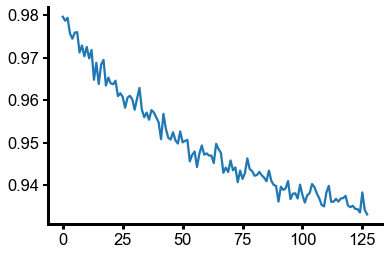

In [80]:
plt.plot(msetest.mean(axis=-1))

In [70]:
sf = 2
pred_test_norm = normimgs(pred_test)
pred_test_up = np.zeros((pred_test.shape[0],sf*pred_test.shape[1],sf*pred_test.shape[2]))
test_vid_norm = normimgs(test_vid)
test_vid_up = np.zeros((test_vid.shape[0],sf*test_vid.shape[1],sf*test_vid.shape[2]))
pred_train_norm = normimgs(pred_train)
pred_train_up = np.zeros((pred_train.shape[0],sf*pred_train.shape[1],sf*pred_train.shape[2]))
train_vid_norm = normimgs(train_vid)
train_vid_up = np.zeros((train_vid.shape[0],sf*train_vid.shape[1],sf*train_vid.shape[2]))
for n in range(pred_test.shape[0]):
    pred_test_up[n] = cv2.resize(pred_test_norm[n],(sf*pred_test.shape[2],sf*pred_test.shape[1]))
    test_vid_up[n] = cv2.resize(test_vid_norm[n],(sf*test_vid.shape[2],sf*test_vid.shape[1]))
    pred_train_up[n] = cv2.resize(pred_train_norm[n],(sf*pred_train.shape[2],sf*pred_train.shape[1]))
    train_vid_up[n] = cv2.resize(train_vid_norm[n],(sf*train_vid.shape[2],sf*train_vid.shape[1]))

cond = 'test'
if cond == 'train':
    tot_samps = np.stack((pred_train_up, train_vid_up))
else:
    tot_samps = np.stack((pred_test_up, test_vid_up))
tot_samps.shape

(2, 6698, 40, 60)

In [41]:
FigPath

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Decoding/fm1')

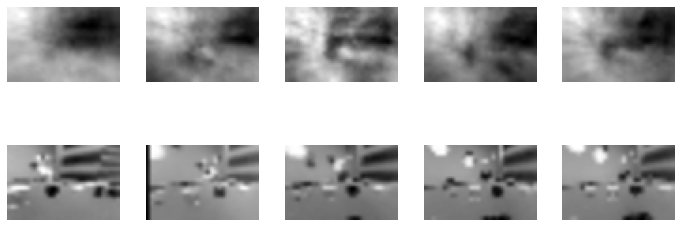

In [43]:
t = 2990#2000
dt = 5
fig, ax = plt.subplots(2,dt,figsize=(10,5))

for n,t in enumerate(np.arange(t,t+dt)):
    ax[0,n].imshow(pred_test_up[t,:,:], cmap='gray')
    ax[0,n].axis('off')
# plt.suptitle('Decoding Frames')
# plt.tight_layout()
# fig.savefig(FigPath/'Decoding_Frame.png',facecolor='white', transparent=True)

# fig2, ax2 = plt.subplots(1,10,figsize=(30,3))
for n,t in enumerate(np.arange(t,t+dt)):
    ax[1,n].imshow(test_vid_up[t,:,:], cmap='gray')
    ax[1,n].axis('off')
# plt.suptitle('Actual Frames')
plt.tight_layout()
fig.savefig(FigPath/'Decoding_Frames2.pdf',facecolor='white', transparent=True)

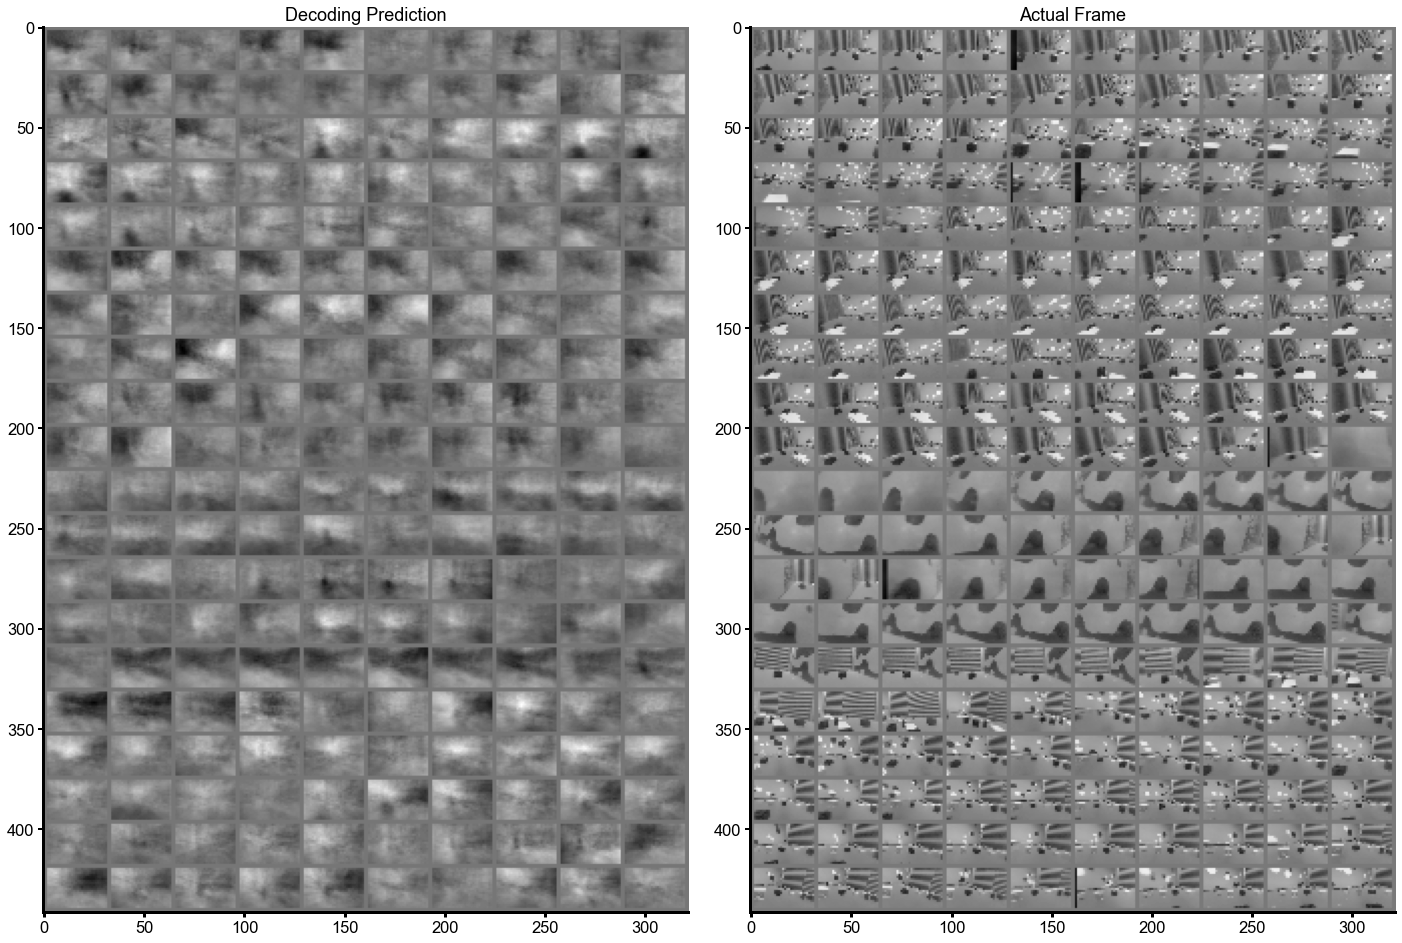

In [35]:
t = 2800#2000
dt = 200
im_grid = torchvision.utils.make_grid(torch.from_numpy(pred_test[t:t+dt,np.newaxis,:,:]),nrow=10,normalize=False)[0]
im_grid2 = torchvision.utils.make_grid(torch.from_numpy(test_vid[t:t+dt,np.newaxis,:,:]),nrow=10,normalize=False)[0]
fig, axs = plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(im_grid, cmap='gray')#.permute(1,2,0))
axs[0].set_title('Decoding Prediction')
axs[1].imshow(im_grid2, cmap='gray')#.permute(1,2,0))
axs[1].set_title('Actual Frame')
plt.tight_layout()
# fig.savefig(FigPath/'DecodedMontage_{}.png'.format(model_type),bbox_inches='tight',transparent=False, facecolor='w')

In [12]:
model_coeff = model.coef_.T.reshape(train_nsp.shape[-1],train_vid.shape[1],train_vid.shape[2])

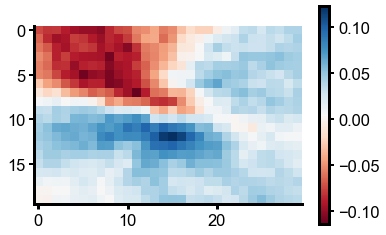

In [13]:
plt.imshow(model_coeff[51],cmap='RdBu')
plt.colorbar()

In [ ]:
im_grid = torchvision.utils.make_grid(torch.from_numpy(model_coeff[:,np.newaxis]),nrow=10,normalize=True)[0]
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(im_grid, cmap='gray')#.permute(1,2,0))
axs.set_title('Decoding Coeff')
plt.tight_layout()
# fig.savefig(FigPath/'DecodingWeights_{}.png'.format(model_type),bbox_inches='tight',transparent=False, facecolor='w')

In [ ]:
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
vid_pred = sp_pred.reshape(sp_pred.shape[0],nks[0],nks[1])
t=20
plt.imshow(vid_pred[t])
plt.colorbar()

In [ ]:
for do_shuffle in [False]:
    # Load Data
    data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)
    windn = 5
    skipn = 3
    ##### Start GLM Parallel Processing #####
    start = time.time()
    nks = np.shape(train_vid)[1:]; nk = nks-[0]*nks[1]*nt_glm_lag
    # Reshape data (video) into (T*n)xN array
    winds_train = sliding_window_view(train_vid,(windn,windn),axis=(1,2))[:,::skipn,::skipn]
    winds_train = winds_train.reshape(winds_train.shape[0],-1,winds_train.shape[-2],winds_train.shape[-1])
    winds_test = sliding_window_view(test_vid,(windn,windn),axis=(1,2))[:,::skipn,::skipn]
    winds_test = winds_test.reshape(winds_test.shape[0],-1,winds_test.shape[-2],winds_test.shape[-1])
#     y_train = train_vid.reshape(train_vid.shape[0],-1)
#     y_test = test_vid.reshape(test_vid.shape[0],-1) 
    
    # Put data into shared memory for parallization 
    train_nsp_r = ray.put(train_nsp)
    test_nsp_r = ray.put(test_nsp)
    train_data_r = ray.put(x_train)
    test_data_r = ray.put(x_test)
    result_ids = []
    # Loop over parameters appending process ids
    for celln in range(train_nsp.shape[1]):
        result_ids.append(do_glm_fit_vis_skl.remote(train_nsp_r, test_nsp_r, train_data_r, test_data_r, celln, model_type, lag_list, model_dt=model_dt))

    print('N_proc:', len(result_ids))
    results_p = ray.get(result_ids)
    print('GLM Add: ', time.time()-start)

    ##### Gather Data and Find Max CC Model #####
    mcc = np.stack([results_p[i][0] for i in range(len(results_p))])
    msta = np.stack([results_p[i][1] for i in range(len(results_p))])
    msp = np.stack([results_p[i][2] for i in range(len(results_p))])
    mpred = np.stack([results_p[i][3] for i in range(len(results_p))])
    mr2 = np.stack([results_p[i][4] for i in range(len(results_p))])

#     nt_glm_lag = len(lag_list)
#     GLM_Data = {'mcc': mcc,
#                 'msta': msta,
#                 'msp': msp,
#                 'mpred': mpred,
#                 'mr2':mr2,}
#     if do_shuffle:
#         ioh5.save(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
#     else:
#         ioh5.save(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
        
#     del train_nsp_r, test_nsp_r, train_data_r, test_data_r, result_ids, results_p, mcc, msta, msp, mpred, mr2,
#     gc.collect()

In [ ]:
train_vid

In [ ]:
x=np.arange(5000).reshape(50,10,10)

In [ ]:
windn = 5
skipn = 3
winds = sliding_window_view(train_vid,(windn,windn),axis=(1,2))[:,::skipn,::skipn]

In [ ]:
winds.shape

# Predciting Future input

In [26]:

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

train_dgaze_p = train_dth + np.diff(train_gz,append=0)
train_dgaze_n = train_dth - np.diff(train_gz,append=0)
test_dgaze_p = test_dth + np.diff(test_gz,append=0)
test_dgaze_n = test_dth - np.diff(test_gz,append=0)
# move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],tr ain_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
move_train = np.hstack((train_dth[:,np.newaxis],train_dphi[:,np.newaxis],train_dgaze_p[:,np.newaxis],train_dgaze_n[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_dth[:,np.newaxis],test_dphi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))

model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
move_train = move_train - np.mean(move_train,axis=0)


lag_list = [5]
Tvid = train_vid.shape[0]
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = train_vid.reshape(len(train_idx),-1)
x_test = test_vid.reshape(len(test_idx),-1)

y_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
y_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

npx = train_vid.shape[1]*train_vid.shape[2]
npxs = train_vid.shape[1:]

In [22]:
lambdas = 1024 * (2**np.arange(0,16))
model = lm.RidgeCV(alphas=lambdas)
model.fit(x_train,y_train)
# sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
vid_pred = model.predict(x_test)
cc = np.corrcoef(y_test,vid_pred)[0,1]
r2 = model.score(vid_pred,y_test)

n=4;ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
x_train_m1 = np.concatenate((x_train,move_train[:,perms[ind]]),axis=1)
x_test_m1 = np.concatenate((x_test,move_test[:,perms[ind]]),axis=1)
lambdas = 1024 * (2**np.arange(0,16))
modelm = lm.RidgeCV(alphas=lambdas)
modelm.fit(x_train_m1,y_train)
# sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
vid_predm = modelm.predict(x_test_m1)
ccm = np.corrcoef(y_test,vid_predm)[0,1]
r2m = r2_score(vid_predm[:,:npx], y_test)


## Mult Model I-IV

In [91]:
# Model I: Visual only
lambdas = 1024 * (2**np.arange(0,16))
modelm1 = lm.RidgeCV(alphas=lambdas)
modelm1.fit(x_train,y_train)
# sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
vid_predm1 = modelm1.predict(x_test)
ccm1 = np.corrcoef(y_test,vid_predm1)[0,1]
r2m1 = model1.score(vid_predm1,y_test)
msem1 = np.mean((y_test-vid_predm1)**2)

# Model II: Visual + Movement
n=4;ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
x_train_m2 = np.concatenate((x_train,move_train[:,perms[ind]]),axis=1)
x_test_m2 = np.concatenate((x_test,move_test[:,perms[ind]]),axis=1)
lambdas = 1024 * (2**np.arange(0,16))
modelm2 = lm.RidgeCV(alphas=lambdas)
modelm2.fit(x_train_m2,y_train)
# sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
vid_predm2 = modelm2.predict(x_test_m2)
ccm2 = np.corrcoef(y_test,vid_predm2)[0,1]
r2m2 = r2_score(vid_predm2[:,:npx], y_test)
msem2 = np.mean((y_test-vid_predm2)**2)

# Model III: Visual + Vis*Mov + Mov
xtr_tot = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
xte_tot = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
W = np.random.normal(loc=0,scale=1/(x_train.shape[-1]+len(titles)*x_train.shape[-1]+len(titles)),size=(x_train.shape[-1]+len(titles)*x_train.shape[-1]+len(titles),x_train.shape[-1]))
x_train_m3 = (xtr_tot @ W)
x_test_m3 = (xte_tot @ W)
lambdas = 1024 * (2**np.arange(0,16))
modelm3 = lm.RidgeCV(alphas=lambdas)
modelm3.fit(x_train_m3,y_train)
# sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
vid_predm3 = modelm3.predict(x_test_m3)
ccm3 = np.corrcoef(y_test,vid_predm3)[0,1]
r2m3 = r2_score(vid_predm3[:,:npx], y_test)
msem3 = np.mean((y_test-vid_predm3)**2)

# Model IV: Vis + Vis*Mov
xtr_tot = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))])))
xte_tot = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))])))
W = np.random.normal(loc=0,scale=1/(x_train.shape[-1]+len(titles)*x_train.shape[-1]),size=(x_train.shape[-1]+len(titles)*x_train.shape[-1],x_train.shape[-1]))
x_train_m4 = (xtr_tot @ W)
x_test_m4 = (xte_tot @ W)
lambdas = 1024 * (2**np.arange(0,16))
modelm4 = lm.RidgeCV(alphas=lambdas)
modelm4.fit(x_train_m4,y_train)
# sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
vid_predm4 = modelm4.predict(x_test_m4)
ccm4 = np.corrcoef(y_test,vid_predm4)[0,1]
r2m4 = r2_score(vid_predm4[:,:npx], y_test)
msem4 = np.mean((y_test-vid_predm4)**2)

# Model V: Vis*Mov + Mov
xtr_tot = np.hstack((np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
xte_tot = np.hstack((np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
W = np.random.normal(loc=0,scale=1/(len(titles)*x_train.shape[-1]+len(titles)),size=(len(titles)*x_train.shape[-1]+len(titles),x_train.shape[-1]))
x_train_m5 = (xtr_tot @ W)
x_test_m5 = (xte_tot @ W)
lambdas = 1024 * (2**np.arange(0,16))
modelm5 = lm.RidgeCV(alphas=lambdas)
modelm5.fit(x_train_m5,y_train)
# sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
vid_predm5 = modelm5.predict(x_test_m5)
ccm5 = np.corrcoef(y_test,vid_predm5)[0,1]
r2m5 = r2_score(vid_predm5[:,:npx], y_test)
msem5 = np.mean((y_test-vid_predm5)**2)

print('Done!')

Done!


Try multilayer ff network. Only changing size of input space, same output space. 600. ReLu and Tanh, RNN??

In [ ]:
msem1,msem2,msem3,msem4,msem5

In [93]:
modelm1.alpha_,modelm2.alpha_,modelm3.alpha_,modelm4.alpha_,modelm5.alpha_

(16384, 16384, 1024, 1024, 8192)

In [94]:
model1.coef_.shape,modelm2.coef_.shape,modelm3.coef_.shape,modelm4.coef_.shape,modelm5.coef_.shape

((600, 600), (600, 604), (600, 600), (600, 600), (600, 600))

In [95]:
ccm1,ccm2,ccm3,ccm4,ccm5

(0.8889563371794056,
 0.8889563371794056,
 0.8889563371794056,
 0.8889563371794056,
 0.8889563371794056)

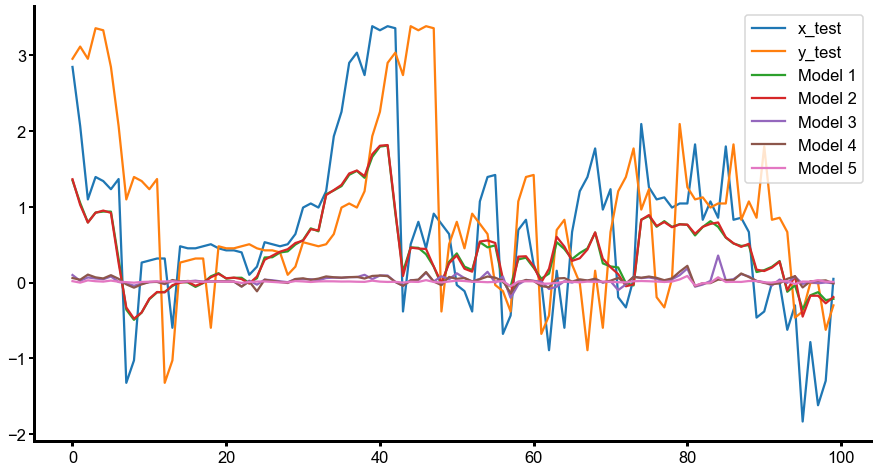

In [96]:
px = 100
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(x_test[:100,px] ,label='x_test')
ax.plot(y_test[:100,px] ,label='y_test')
ax.plot(vid_predm1[:100,px] ,label='Model 1')
ax.plot(vid_predm2[:100,px] ,label='Model 2')
ax.plot(vid_predm3[:100,px] ,label='Model 3')
ax.plot(vid_predm4[:100,px] ,label='Model 4')
ax.plot(vid_predm5[:100,px] ,label='Model 5')
plt.legend()
fig.savefig(FigPath/'ExamplePixelPrediction.png',bbox_inches='tight',transparent=False, facecolor='w')

In [97]:
import matplotlib.gridspec as gridspec

In [98]:
sf = 4
y_test_up = np.zeros((y_test.shape[0],sf*model_vid_sm.shape[-2],sf*model_vid_sm.shape[-1]),dtype=np.float32)
vid_predm1_up = np.zeros((vid_predm1.shape[0],sf*model_vid_sm.shape[-2],sf*model_vid_sm.shape[-1]),np.float32)
vid_predm2_up = np.zeros((vid_predm2.shape[0],sf*model_vid_sm.shape[-2],sf*model_vid_sm.shape[-1]),np.float32)
vid_predm3_up = np.zeros((vid_predm3.shape[0],sf*model_vid_sm.shape[-2],sf*model_vid_sm.shape[-1]),np.float32)
vid_predm4_up = np.zeros((vid_predm4.shape[0],sf*model_vid_sm.shape[-2],sf*model_vid_sm.shape[-1]),np.float32)
vid_predm5_up = np.zeros((vid_predm5.shape[0],sf*model_vid_sm.shape[-2],sf*model_vid_sm.shape[-1]),np.float32)
for n in range(y_test.shape[0]):
    
#     for t in range(msta.shape[1]):
    y_test_up[n] = cv2.resize(y_test[n],(sf*model_vid_sm.shape[-1],sf*model_vid_sm.shape[-2]))
    vid_predm1_up[n] = cv2.resize(vid_predm1[n],(sf*model_vid_sm.shape[-1],sf*model_vid_sm.shape[-2]))
    vid_predm2_up[n] = cv2.resize(vid_predm2[n],(sf*model_vid_sm.shape[-1],sf*model_vid_sm.shape[-2]))
    vid_predm3_up[n] = cv2.resize(vid_predm3[n],(sf*model_vid_sm.shape[-1],sf*model_vid_sm.shape[-2]))
    vid_predm4_up[n] = cv2.resize(vid_predm4[n],(sf*model_vid_sm.shape[-1],sf*model_vid_sm.shape[-2]))
    vid_predm5_up[n] = cv2.resize(vid_predm5[n],(sf*model_vid_sm.shape[-1],sf*model_vid_sm.shape[-2]))

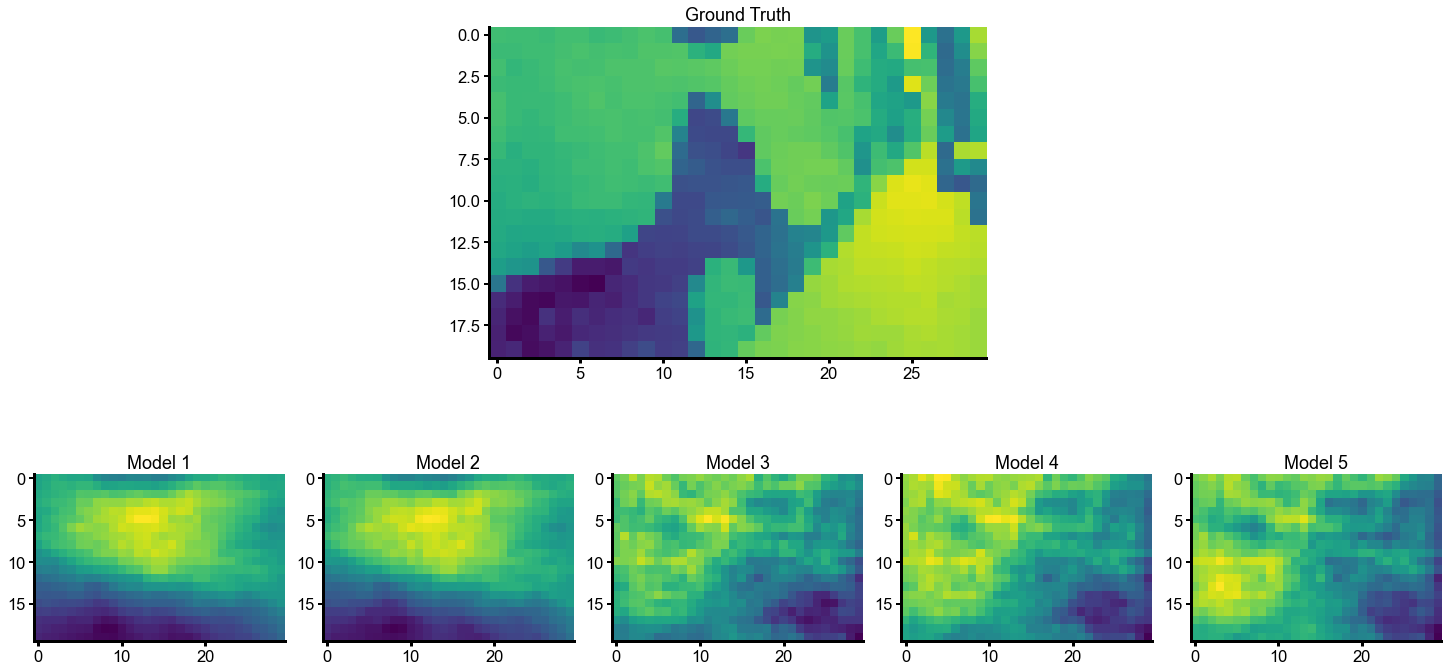

In [103]:
t = 25
fig2 = plt.figure(constrained_layout=True, figsize=(20,10))
spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, :])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[1, 1])
f2_ax4 = fig2.add_subplot(spec2[1, 2])
f2_ax5 = fig2.add_subplot(spec2[1, 3])
f2_ax6 = fig2.add_subplot(spec2[1, 4])

f2_ax1.imshow(y_test[t].reshape(npxs))
f2_ax1.set_title('Ground Truth')
f2_ax2.imshow(vid_predm1[t].reshape(npxs))
f2_ax2.set_title('Model 1')
f2_ax3.imshow(vid_predm2[t].reshape(npxs))
f2_ax3.set_title('Model 2')
f2_ax4.imshow(vid_predm3[t].reshape(npxs))
f2_ax4.set_title('Model 3')
f2_ax5.imshow(vid_predm4[t].reshape(npxs))
f2_ax5.set_title('Model 4')
f2_ax6.imshow(vid_predm5[t].reshape(npxs))
f2_ax6.set_title('Model 5')
fig2.savefig(FigPath/'ExampleFramePrediction.png',bbox_inches='tight',transparent=False, facecolor='w')

## Pytorch

In [58]:
SetRange = transforms.Lambda(lambda X: 2 * X - 1.)
SetScale = transforms.Lambda(lambda X: X/X.sum(0).expand_as(X))

transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.ConvertImageDtype(torch.float32),
                                SetRange])
transform(x_train_m2).shape

torch.Size([1, 15628, 604])

In [ ]:
y_train,y_test,x_train_m1,x_test_m1,x_train_m2,x_test_m2,xtr_tot_m3,xte_tot_m3,xtr_tot_m4,xte_tot_m4,xtr_tot_m5,xte_tot_m5,

In [8]:

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

train_dgaze_p = train_dth + np.diff(train_gz,append=0)
train_dgaze_n = train_dth - np.diff(train_gz,append=0)
test_dgaze_p = test_dth + np.diff(test_gz,append=0)
test_dgaze_n = test_dth - np.diff(test_gz,append=0)
# move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],tr ain_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
move_train = np.hstack((train_dth[:,np.newaxis],train_dphi[:,np.newaxis],train_dgaze_p[:,np.newaxis],train_dgaze_n[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_dth[:,np.newaxis],test_dphi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))

model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
move_train = move_train - np.mean(move_train,axis=0)


lag_list = [1]
Tvid = train_vid.shape[0]
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = train_vid.reshape(len(train_idx),-1)
x_test = test_vid.reshape(len(test_idx),-1)

y_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
y_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

npx = train_vid.shape[1]*train_vid.shape[2]
npxs = train_vid.shape[1:]

Linear inputs, fixed hidden, nonlinearity, lienar readout

In [50]:
RNN_Size = 25
lr = .001
nonlinearity =  nn.Tanh()# 'nn.ReLU() #
# Model I: Visual only
lambdas = 1024 * (2**np.arange(0,16))
xtr_m1 = x_train.copy()
xte_m1 = x_test.copy()
modelm1 = nn.Sequential(nn.Linear(xtr_m1.shape[-1],RNN_Size), 
                        nonlinearity, 
                        nn.Linear(RNN_Size,npx)).to(device)
# nn.RNN(x_train.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
# lin_m1 = nn.Linear(RNN_Size,npx).to(device)
# optim_m1 = optim.Adam(lr=lr,params=list(modelm1.parameters()) + list(lin_m1.parameters()))
optim_m1 = optim.AdamW(lr=lr,params=modelm1.parameters(), weight_decay=.1)

# Model II: Visual + Movement
n=4;ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
xtr_m2 = np.concatenate((x_train,move_train[:,perms[ind]]),axis=1)
xte_m2 = np.concatenate((x_test,move_test[:,perms[ind]]),axis=1)
lambdas = 1024 * (2**np.arange(0,16))
modelm2 =  nn.Sequential(nn.Linear(xtr_m2.shape[-1],RNN_Size), 
                         nonlinearity, 
                         nn.Linear(RNN_Size,npx)).to(device)
# nn.RNN(x_train_m2.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
# lin_m2 = nn.Linear(RNN_Size,npx).to(device)
# optim_m2 = optim.Adam(lr=lr,params=list(modelm2.parameters()) + list(lin_m2.parameters()))
optim_m2 = optim.AdamW(lr=lr,params=modelm2.parameters(), weight_decay=.1)

# Model III: Visual + Vis*Mov + Mov
xtr_m3 = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
xte_m3 = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
W = np.random.normal(loc=0,scale=1/(x_train.shape[-1]+len(titles)*x_train.shape[-1]+len(titles)),size=(x_train.shape[-1]+len(titles)*x_train.shape[-1]+len(titles),x_train.shape[-1]))
lambdas = 1024 * (2**np.arange(0,16))
modelm3 =  nn.Sequential(nn.Linear(xtr_m3.shape[-1],RNN_Size), 
                         nonlinearity, 
                         nn.Linear(RNN_Size,npx)).to(device)
# nn.RNN(xtr_tot_m3.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
# lin_m3 = nn.Linear(RNN_Size,npx).to(device)
# optim_m3 = optim.Adam(lr=lr,params=list(modelm3.parameters()) + list(lin_m3.parameters()))
optim_m3 = optim.AdamW(lr=lr,params=modelm3.parameters(), weight_decay=.1)

# Model IV: Vis + Vis*Mov
xtr_m4 = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))])))
xte_m4 = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))])))
W = np.random.normal(loc=0,scale=1/(x_train.shape[-1]+len(titles)*x_train.shape[-1]),size=(x_train.shape[-1]+len(titles)*x_train.shape[-1],x_train.shape[-1]))
lambdas = 1024 * (2**np.arange(0,16))
modelm4 =  nn.Sequential(nn.Linear(xtr_m4.shape[-1],RNN_Size), 
                         nonlinearity, 
                         nn.Linear(RNN_Size,npx)).to(device)
# nn.RNN(xtr_tot_m4.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
# lin_m4 = nn.Linear(RNN_Size,npx).to(device)
# optim_m4 = optim.Adam(lr=lr,params=list(modelm4.parameters()) + list(lin_m4.parameters()))
optim_m4 = optim.AdamW(lr=lr,params=modelm4.parameters(), weight_decay=.1)

# Model V: Vis*Mov + Mov
xtr_m5 = np.hstack((np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
xte_m5 = np.hstack((np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
W = np.random.normal(loc=0,scale=1/(len(titles)*x_train.shape[-1]+len(titles)),size=(len(titles)*x_train.shape[-1]+len(titles),x_train.shape[-1]))
lambdas = 1024 * (2**np.arange(0,16))
modelm5 =  nn.Sequential(nn.Linear(xtr_m5.shape[-1],RNN_Size), 
                         nonlinearity, 
                         nn.Linear(RNN_Size,npx)).to(device)
# nn.RNN(xtr_tot_m5.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
# lin_m5 = nn.Linear(RNN_Size,npx).to(device)
# optim_m5 = optim.Adam(lr=lr,params=list(modelm5.parameters()) + list(lin_m5.parameters()))
optim_m5 = optim.Adam(lr=lr,params=modelm5.parameters())

In [51]:

ytr = torch.from_numpy(y_train.astype(np.float32)).to(device)
yte = torch.from_numpy(y_test.astype(np.float32)).to(device)
xtr_tot_m1 = torch.from_numpy(xtr_m1.reshape(1,xtr_m1.shape[0],xtr_m1.shape[-1]).astype(np.float32)).to(device)
xte_tot_m1 = torch.from_numpy(xte_m1.reshape(1,xte_m1.shape[0],xte_m1.shape[-1]).astype(np.float32)).to(device)
xtr_tot_m2 = torch.from_numpy(xtr_m2.reshape(1,xtr_m2.shape[0],xtr_m2.shape[-1]).astype(np.float32)).to(device)
xte_tot_m2 = torch.from_numpy(xte_m2.reshape(1,xte_m2.shape[0],xte_m2.shape[-1]).astype(np.float32)).to(device)
xtr_tot_m3 = torch.from_numpy(xtr_m3.reshape(1,xtr_m3.shape[0],xtr_m3.shape[-1]).astype(np.float32)).to(device)
xte_tot_m3 = torch.from_numpy(xte_m3.reshape(1,xte_m3.shape[0],xte_m3.shape[-1]).astype(np.float32)).to(device)
xtr_tot_m4 = torch.from_numpy(xtr_m4.reshape(1,xtr_m4.shape[0],xtr_m4.shape[-1]).astype(np.float32)).to(device)
xte_tot_m4 = torch.from_numpy(xte_m4.reshape(1,xte_m4.shape[0],xte_m4.shape[-1]).astype(np.float32)).to(device)
xtr_tot_m5 = torch.from_numpy(xtr_m5.reshape(1,xtr_m5.shape[0],xtr_m5.shape[-1]).astype(np.float32)).to(device)
xte_tot_m5 = torch.from_numpy(xte_m5.reshape(1,xte_m5.shape[0],xte_m5.shape[-1]).astype(np.float32)).to(device)
print('Done!')

Done!


In [52]:
Nbatches = 1000
lossfn = nn.MSELoss()
Loss_trace_train = np.zeros((5,Nbatches))
Loss_trace_test = np.zeros((5,Nbatches))

for n in tqdm(np.arange(Nbatches)):
    out1= modelm1(xtr_tot_m1)
#     out1 = lin_m1(out1)
    out2= modelm2(xtr_tot_m2)
#     out2 = lin_m2(out2)
    out3= modelm3(xtr_tot_m3)
#     out3 = lin_m3(out3)
    out4= modelm4(xtr_tot_m4)
#     out4 = lin_m4(out4)
    out5= modelm5(xtr_tot_m5)
#     out5 = lin_m5(out5)
    optim_m1.zero_grad()
    optim_m2.zero_grad()
    optim_m3.zero_grad()
    optim_m4.zero_grad()
    optim_m5.zero_grad()
    loss1 = lossfn(out1.squeeze(),ytr)
    loss2 = lossfn(out2.squeeze(),ytr)
    loss3 = lossfn(out3.squeeze(),ytr)
    loss4 = lossfn(out4.squeeze(),ytr)
    loss5 = lossfn(out5.squeeze(),ytr)
    loss1.backward()
    loss2.backward()
    loss3.backward()
    loss4.backward()
    loss5.backward()
    optim_m1.step()
    optim_m2.step()
    optim_m3.step()
    optim_m4.step()
    optim_m5.step()
    v_loss1 = lossfn(modelm1(xte_tot_m1).squeeze(),yte)
    v_loss2 = lossfn(modelm2(xte_tot_m2).squeeze(),yte)
    v_loss3 = lossfn(modelm3(xte_tot_m3).squeeze(),yte)
    v_loss4 = lossfn(modelm4(xte_tot_m4).squeeze(),yte)
    v_loss5 = lossfn(modelm5(xte_tot_m5).squeeze(),yte)
    Loss_trace_train[:,n] = np.array([loss1.item(),loss2.item(),loss3.item(),loss4.item(),loss5.item()])
    Loss_trace_test[:,n] = np.array([v_loss1.item(),v_loss2.item(),v_loss3.item(),v_loss4.item(),v_loss5.item()])
out1 = modelm1(xte_tot_m1)
# out1 = lin_m1(out1)
out2 = modelm2(xte_tot_m2)
# out2 = lin_m2(out2)
out3 = modelm3(xte_tot_m3)
# out3 = lin_m3(out3)
out4 = modelm4(xte_tot_m4)
# out4 = lin_m4(out4)
out5 = modelm5(xte_tot_m5)
# out5 = lin_m5(out5)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [53]:
Loss_trace_train[:,-1], Loss_trace_test[:,-1] 

(array([0.61789459, 0.61771721, 0.6051811 , 0.6052686 , 0.83298761]),
 array([0.64821744, 0.64809477, 0.73782927, 0.73304331, 1.20283318]))

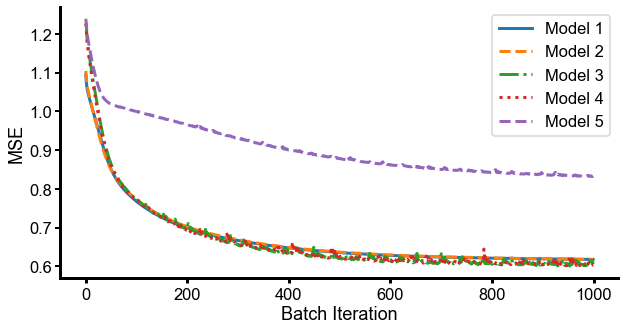

In [54]:
ls = ['-', '--', '-.', ':','--']
fig,ax = plt.subplots(figsize=(10,5))
for n in range(Loss_trace_train.shape[0]):
    ax.plot(Loss_trace_train[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
#     ax.plot(Loss_trace_test[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
    
ax.set_xlabel('Batch Iteration')
ax.set_ylabel('MSE')
ax.legend()
# fig.savefig(FigPath/'FF_Loss_{}_Traces_{}.png'.format('Train',nonlinearity),bbox_inches='tight',transparent=False, facecolor='w')

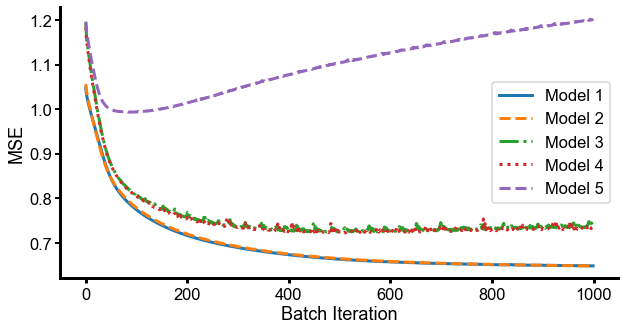

In [55]:
# ls = ['-', '--', '-.', ':','--']
fig,ax = plt.subplots(figsize=(10,5))
for n in range(Loss_trace_train.shape[0]):
#     ax.plot(Loss_trace_train[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
    ax.plot(Loss_trace_test[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
    
ax.set_xlabel('Batch Iteration')
ax.set_ylabel('MSE')
ax.legend()
# fig.savefig(FigPath/'FF_Loss_{}_Traces_{}.png'.format('Test',nonlinearity),bbox_inches='tight',transparent=False, facecolor='w')

In [26]:
y_test1 = y_test.cpu().detach().numpy().reshape((y_test.shape[0],)+npxs)
out1 = out1.cpu().detach().numpy().reshape((out1.shape[1],)+npxs)
out2 = out2.cpu().detach().numpy().reshape((out2.shape[1],)+npxs)
out3 = out3.cpu().detach().numpy().reshape((out3.shape[1],)+npxs)
out4 = out4.cpu().detach().numpy().reshape((out4.shape[1],)+npxs)
out5 = out5.cpu().detach().numpy().reshape((out5.shape[1],)+npxs)


(-0.5, 29.5, 19.5, -0.5)

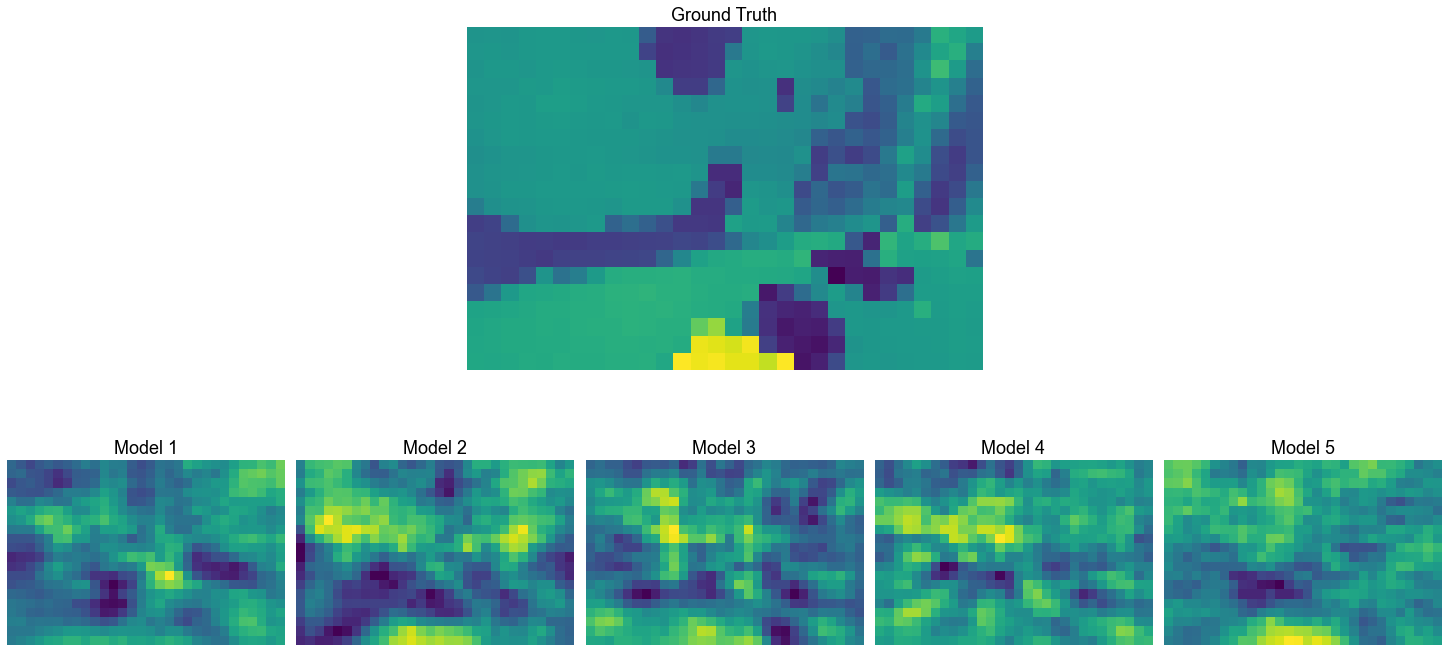

In [27]:
t = 150
fig2 = plt.figure(constrained_layout=True, figsize=(20,10))
spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, :])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[1, 1])
f2_ax4 = fig2.add_subplot(spec2[1, 2])
f2_ax5 = fig2.add_subplot(spec2[1, 3])
f2_ax6 = fig2.add_subplot(spec2[1, 4])

f2_ax1.imshow(y_test1[t])
f2_ax1.set_title('Ground Truth')
f2_ax1.axis('off')
f2_ax2.imshow(out1[t])
f2_ax2.set_title('Model 1')
f2_ax2.axis('off')
f2_ax3.imshow(out2[t])
f2_ax3.set_title('Model 2')
f2_ax3.axis('off')
f2_ax4.imshow(out3[t])
f2_ax4.set_title('Model 3')
f2_ax4.axis('off')
f2_ax5.imshow(out4[t])
f2_ax5.set_title('Model 4')
f2_ax5.axis('off')
f2_ax6.imshow(out5[t])
f2_ax6.set_title('Model 5')
f2_ax6.axis('off')
# fig2.savefig(FigPath/'FF_ExampleFramePrediction_{}.png'.format(nonlinearity),bbox_inches='tight',transparent=False, facecolor='w')

In [253]:
FigPath

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Decoding/fm1')

### Pytorch RNN

In [41]:
RNN_Size = 25
lr = .001
nonlinearity = 'tanh' #nn.Tanh()# 'nn.ReLU() #
# Model I: Visual only
lambdas = 1024 * (2**np.arange(0,16))
xtr_m1 = x_train.copy()
xte_m1 = x_test.copy()
# modelm1 = nn.Sequential(nn.Linear(xtr_m1.shape[-1],RNN_Size), 
#                         nonlinearity, 
#                         nn.Linear(RNN_Size,npx)).to(device)
modelm1 = nn.RNN(xtr_m1.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
lin_m1 = nn.Linear(RNN_Size,npx).to(device)
optim_m1 = optim.AdamW(lr=lr,params=list(modelm1.parameters()) + list(lin_m1.parameters()), weight_decay=.01)
# optim_m1 = optim.Adam(lr=lr,params=modelm1.parameters())

# Model II: Visual + Movement
n=4;ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
xtr_m2 = np.concatenate((x_train,move_train[:,perms[ind]]),axis=1)
xte_m2 = np.concatenate((x_test,move_test[:,perms[ind]]),axis=1)
lambdas = 1024 * (2**np.arange(0,16))
# modelm2 =  nn.Sequential(nn.Linear(xtr_m2.shape[-1],RNN_Size), 
#                          nonlinearity, 
#                          nn.Linear(RNN_Size,npx)).to(device)
modelm2 = nn.RNN(xtr_m2.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
lin_m2 = nn.Linear(RNN_Size,npx).to(device)
optim_m2 = optim.AdamW(lr=lr,params=list(modelm2.parameters()) + list(lin_m2.parameters()), weight_decay=.01)
# optim_m2 = optim.Adam(lr=lr,params=modelm2.parameters())

# Model III: Visual + Vis*Mov + Mov
xtr_m3 = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
xte_m3 = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
W = np.random.normal(loc=0,scale=1/(x_train.shape[-1]+len(titles)*x_train.shape[-1]+len(titles)),size=(x_train.shape[-1]+len(titles)*x_train.shape[-1]+len(titles),x_train.shape[-1]))
lambdas = 1024 * (2**np.arange(0,16))
# modelm3 =  nn.Sequential(nn.Linear(xtr_m3.shape[-1],RNN_Size), 
#                          nonlinearity, 
#                          nn.Linear(RNN_Size,npx)).to(device)
modelm3 = nn.RNN(xtr_m3.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
lin_m3 = nn.Linear(RNN_Size,npx).to(device)
optim_m3 = optim.AdamW(lr=lr,params=list(modelm3.parameters()) + list(lin_m3.parameters()), weight_decay=.01)
# optim_m3 = optim.Adam(lr=lr,params=modelm3.parameters())

# Model IV: Vis + Vis*Mov
xtr_m4 = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))])))
xte_m4 = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))])))
W = np.random.normal(loc=0,scale=1/(x_train.shape[-1]+len(titles)*x_train.shape[-1]),size=(x_train.shape[-1]+len(titles)*x_train.shape[-1],x_train.shape[-1]))
lambdas = 1024 * (2**np.arange(0,16))
# modelm4 =  nn.Sequential(nn.Linear(xtr_m4.shape[-1],RNN_Size), 
#                          nonlinearity, 
#                          nn.Linear(RNN_Size,npx)).to(device)
modelm4 = nn.RNN(xtr_m4.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
lin_m4 = nn.Linear(RNN_Size,npx).to(device)
optim_m4 = optim.AdamW(lr=lr,params=list(modelm4.parameters()) + list(lin_m4.parameters()), weight_decay=.01)
# optim_m4 = optim.Adam(lr=lr,params=modelm4.parameters())

# Model V: Vis*Mov + Mov
xtr_m5 = np.hstack((np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
xte_m5 = np.hstack((np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
W = np.random.normal(loc=0,scale=1/(len(titles)*x_train.shape[-1]+len(titles)),size=(len(titles)*x_train.shape[-1]+len(titles),x_train.shape[-1]))
lambdas = 1024 * (2**np.arange(0,16))
# modelm5 =  nn.Sequential(nn.Linear(xtr_m5.shape[-1],RNN_Size), 
#                          nonlinearity, 
#                          nn.Linear(RNN_Size,npx)).to(device)
modelm5 = nn.RNN(xtr_m5.shape[-1],RNN_Size,nonlinearity=nonlinearity).to(device)
lin_m5 = nn.Linear(RNN_Size,npx).to(device)
optim_m5 = optim.AdamW(lr=lr,params=list(modelm5.parameters()) + list(lin_m5.parameters()), weight_decay=.01)
# optim_m5 = optim.Adam(lr=lr,params=modelm5.parameters())

In [44]:
Nbatches = 1000
lossfn = nn.MSELoss()
Loss_trace_train = np.zeros((5,Nbatches))
Loss_trace_test = np.zeros((5,Nbatches))

for n in tqdm(np.arange(Nbatches)):
    out1,_ = modelm1(xtr_tot_m1)
    out1 = lin_m1(out1)
    out2,_ = modelm2(xtr_tot_m2)
    out2 = lin_m2(out2)
    out3,_ = modelm3(xtr_tot_m3)
    out3 = lin_m3(out3)
    out4,_ = modelm4(xtr_tot_m4)
    out4 = lin_m4(out4)
    out5,_ = modelm5(xtr_tot_m5)
    out5 = lin_m5(out5)
    optim_m1.zero_grad()
    optim_m2.zero_grad()
    optim_m3.zero_grad()
    optim_m4.zero_grad()
    optim_m5.zero_grad()
    loss1 = lossfn(out1.squeeze(),ytr)
    loss2 = lossfn(out2.squeeze(),ytr)
    loss3 = lossfn(out3.squeeze(),ytr)
    loss4 = lossfn(out4.squeeze(),ytr)
    loss5 = lossfn(out5.squeeze(),ytr)
    loss1.backward()
    loss2.backward()
    loss3.backward()
    loss4.backward()
    loss5.backward()
    optim_m1.step()
    optim_m2.step()
    optim_m3.step()
    optim_m4.step()
    optim_m5.step()
    v_loss1 = lossfn(lin_m1(modelm1(xte_tot_m1)[0]).squeeze(),yte)
    v_loss2 = lossfn(lin_m2(modelm2(xte_tot_m2)[0]).squeeze(),yte)
    v_loss3 = lossfn(lin_m3(modelm3(xte_tot_m3)[0]).squeeze(),yte)
    v_loss4 = lossfn(lin_m4(modelm4(xte_tot_m4)[0]).squeeze(),yte)
    v_loss5 = lossfn(lin_m5(modelm5(xte_tot_m5)[0]).squeeze(),yte)
    Loss_trace_train[:,n] = np.array([loss1.item(),loss2.item(),loss3.item(),loss4.item(),loss5.item()])
    Loss_trace_test[:,n] = np.array([v_loss1.item(),v_loss2.item(),v_loss3.item(),v_loss4.item(),v_loss5.item()])
out1,_ = modelm1(xte_tot_m1)
out1 = lin_m1(out1)
out2,_ = modelm2(xte_tot_m2)
out2 = lin_m2(out2)
out3,_ = modelm3(xte_tot_m3)
out3 = lin_m3(out3)
out4,_ = modelm4(xte_tot_m4)
out4 = lin_m4(out4)
out5,_ = modelm5(xte_tot_m5)
out5 = lin_m5(out5)

  0%|          | 0/1000 [00:00<?, ?it/s]

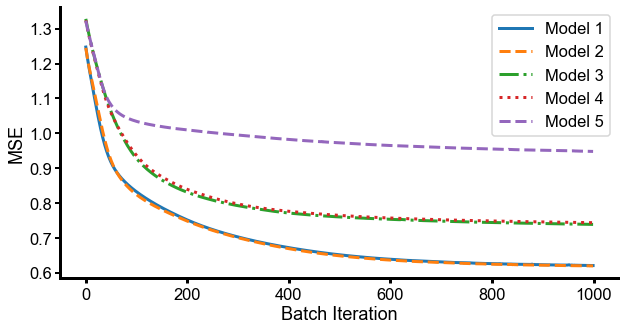

In [45]:
ls = ['-', '--', '-.', ':','--']
fig,ax = plt.subplots(figsize=(10,5))
for n in range(Loss_trace_train.shape[0]):
    ax.plot(Loss_trace_train[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
#     ax.plot(Loss_trace_test[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
    
ax.set_xlabel('Batch Iteration')
ax.set_ylabel('MSE')
ax.legend()
# fig.savefig(FigPath/'FF_Loss_{}_Traces_{}.png'.format('Train',nonlinearity),bbox_inches='tight',transparent=False, facecolor='w')

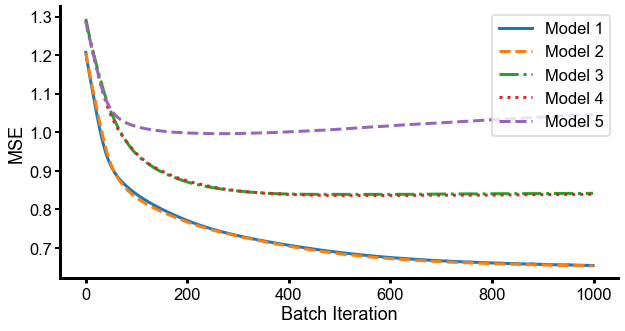

In [46]:
# ls = ['-', '--', '-.', ':','--']
fig,ax = plt.subplots(figsize=(10,5))
for n in range(Loss_trace_train.shape[0]):
#     ax.plot(Loss_trace_train[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
    ax.plot(Loss_trace_test[n],label='Model {}'.format(n+1),lw=3,ls=ls[n])
    
ax.set_xlabel('Batch Iteration')
ax.set_ylabel('MSE')
ax.legend()
# fig.savefig(FigPath/'FF_Loss_{}_Traces_{}.png'.format('Test',nonlinearity),bbox_inches='tight',transparent=False, facecolor='w')

In [48]:
y_test1 = yte.cpu().detach().numpy().reshape((y_test.shape[0],)+npxs)
out1 = out1.cpu().detach().numpy().reshape((out1.shape[1],)+npxs)
out2 = out2.cpu().detach().numpy().reshape((out2.shape[1],)+npxs)
out3 = out3.cpu().detach().numpy().reshape((out3.shape[1],)+npxs)
out4 = out4.cpu().detach().numpy().reshape((out4.shape[1],)+npxs)
out5 = out5.cpu().detach().numpy().reshape((out5.shape[1],)+npxs)


(-0.5, 29.5, 19.5, -0.5)

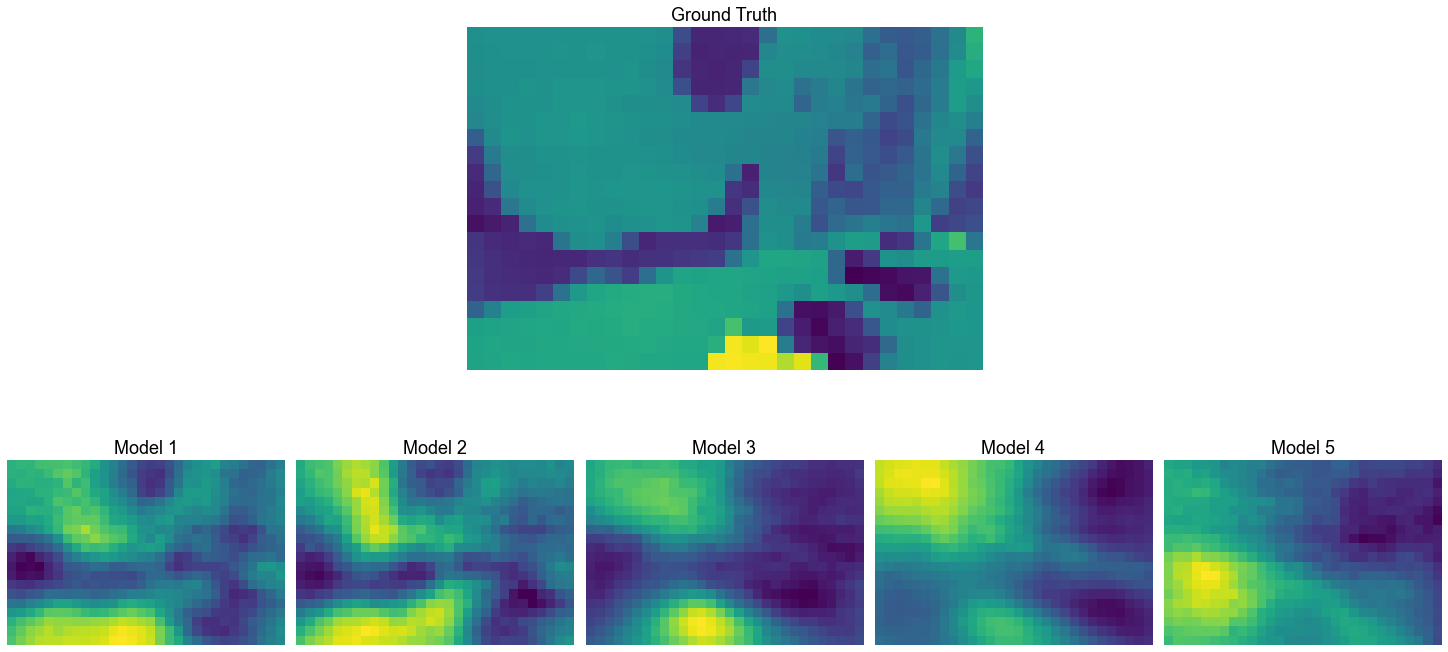

In [49]:
t = 150
fig2 = plt.figure(constrained_layout=True, figsize=(20,10))
spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, :])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[1, 1])
f2_ax4 = fig2.add_subplot(spec2[1, 2])
f2_ax5 = fig2.add_subplot(spec2[1, 3])
f2_ax6 = fig2.add_subplot(spec2[1, 4])

f2_ax1.imshow(y_test1[t])
f2_ax1.set_title('Ground Truth')
f2_ax1.axis('off')
f2_ax2.imshow(out1[t])
f2_ax2.set_title('Model 1')
f2_ax2.axis('off')
f2_ax3.imshow(out2[t])
f2_ax3.set_title('Model 2')
f2_ax3.axis('off')
f2_ax4.imshow(out3[t])
f2_ax4.set_title('Model 3')
f2_ax4.axis('off')
f2_ax5.imshow(out4[t])
f2_ax5.set_title('Model 4')
f2_ax5.axis('off')
f2_ax6.imshow(out5[t])
f2_ax6.set_title('Model 5')
f2_ax6.axis('off')
# fig2.savefig(FigPath/'FF_ExampleFramePrediction_{}.png'.format(nonlinearity),bbox_inches='tight',transparent=False, facecolor='w')

# Linear Models

## Regression on Movement

In [ ]:
do_shuffle = False
data = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True, free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
Y_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
Y_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#


In [ ]:
model_type = 'ridgecv'
if model_type == 'elasticnetcv':
    model = make_pipeline(StandardScaler(), lm.ElasticNetCV()) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
elif model_type == 'ridgecv':
    model = make_pipeline(StandardScaler(), lm.RidgeCV())

model.fit(train_nsp, Y_train)
pred_train = model.predict(train_nsp)
pred_test = model.predict(test_nsp)
train_score = model.score(train_nsp,Y_train)
test_score = model.score(test_nsp, Y_test)
print('Train Score:', train_score, 'Test Score:', test_score)
# print(model['model_type'].coef_[22])
cc = np.corrcoef(pred_test,Y_test)
print('cc={:.02f}'.format(cc[0,1]))


In [ ]:
##### Flip test and train #####
# model2 = make_pipeline(StandardScaler(), lm.RidgeCV())
# model2.fit(test_nsp, Y_test)
# pred_train = model2.predict(test_nsp)
# pred_test = model2.predict(train_nsp)
# train_score = model2.score(test_nsp,Y_test)
# test_score = model2.score(train_nsp, Y_train)
# print('Train Score:', train_score, 'Test Score:', test_score)
# print(model2['ridgecv'].coef_[22])

In [ ]:
model[model_type].alpha_

In [ ]:
pred_test.shape

In [ ]:
modeln = 3
plt.plot(Y_test[:100,modeln])

plt.plot(pred_test[:100,modeln])


In [ ]:
Y_train.shape

In [ ]:
t = 0
dt = 10000
plt.plot(np.arange(t,t+dt),Y_train[t:t+dt])
plt.plot(np.arange(t,t+dt), pred_train[t:t+dt])

In [ ]:
t = 100
dt = 100
fig, axs = plt.subplots(1,figsize=(7,5))
cc = np.corrcoef(Y_test,pred_test)[0,1]
axs.plot(np.arange(t,t+dt)*model_dt,Y_test[t:t+dt], 'k', label='Ground Truth')
axs.plot(np.arange(t,t+dt)*model_dt,pred_test[t:t+dt], 'r', label='Prediction')
axs.set_title('CorrCoeff: {:.02f}'.format(cc))
axs.set_xlabel('Time (s)')
# axs.set_ylabel('Eye Phi Angle')
axs.legend()
plt.tight_layout()
# fig.savefig(FigPath/'LinearRegressionExample_phi.png',bbox_inches='tight',transparent=False, facecolor='w')

In [ ]:
np.corrcoef(Y_train,pred_train)

In [ ]:
np.corrcoef(Y_test,pred_test)

In [ ]:
plt.scatter(Y_test,pred_test, alpha=.1)

In [ ]:
# plt.plot(model['elasticnetcv'].coef_)
plt.plot(model['ridgecv'].coef_)


In [ ]:
pred_test.shape,Y_test.shape

# Autocorrelation of the th, vid 

In [ ]:
from scipy.ndimage import uniform_filter1d 

In [ ]:
np.corrcoef(test_th, test_nsp[:,22])

In [ ]:
xcorr_data = plt.xcorr(test_th, test_nsp[:,22], maxlags=100)
lags, xscore = xcorr_data[0], xcorr_data[1]

In [ ]:
lags[np.argmax(xscore)], xscore[np.argmax(xscore)],lags[np.argmin(xscore)], xscore[np.argmin(xscore)]

In [ ]:
plt.acorr(train_th, maxlags=100)

## Regression on Video

In [316]:
train_vid, test_vid, train_nsp, test_nsp, train_th, test_th, train_phi, test_phi, train_roll, test_roll, train_pitch, test_pitch, train_t, test_t, train_dth, test_dth, train_dphi, test_dphi = \
train_test_split(model_vid_sm, model_nsp, model_th, model_phi, model_roll, model_pitch, model_t, model_dth, model_dphi, train_size=.6, shuffle=False, random_state=0)

In [318]:
Y_train = train_vid.reshape(train_vid.shape[0],-1)#[:,10:11] # np.stack((train_roll, train_pitch),axis=1) # 
Y_test = test_vid.reshape(test_vid.shape[0],-1)#[:,10:11] # np.stack((test_roll, test_pitch),axis=1) # 

In [319]:
@ray.remote
def multi_regression(train_nsp,Y_train,test_nsp,Y_test,idx,model_type):
    if model_type == 'elasticnetcv':
        model = lm.ElasticNetCV() # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
    elif model_type == 'ridgecv':
        model = lm.RidgeCV(alphas=np.arange(100,10000,1000))
        
    # MultiTaskElasticNetCV(n_jobs=-1)) # RidgeCV()# MultiTaskLassoCV(n_jobs=-1) # RidgeCV() # LinearRegression(n_jobs=-1) #
    # register_ray()
    # with joblib.parallel_backend('ray'):
    model.fit(train_nsp, Y_train[:,idx])
    pred_train = model.predict(train_nsp)
    pred_test = model.predict(test_nsp)
    model_coeff = model.coef_
#     print('Train Score:', model.score(train_nsp,Y_train), 'Test Score:', model.score(test_nsp, Y_test))
    train_score = np.corrcoef(pred_train,Y_train[:,idx])[0,1]
    test_score = np.corrcoef(pred_test, Y_test[:,idx])[0,1]
    alphas = model.alpha_
    return pred_train, pred_test, train_score, test_score, model_coeff, alphas


In [320]:
model_type = 'ridgecv'

start = time.time()
train_nsp_r = ray.put(train_nsp)
Y_train_r = ray.put(Y_train)
test_nsp_r = ray.put(test_nsp)
Y_test_r = ray.put(Y_test)
result_ids = []
[result_ids.append(multi_regression.remote(train_nsp_r,Y_train_r,test_nsp_r,Y_test_r,idx,model_type)) for idx in range(0, train_vid.shape[-1]*train_vid.shape[-2])]
results_p = ray.get(result_ids)
print('MultiReg Time: ', time.time() - start)

MultiReg Time:  20.296212673187256


In [321]:
pred_train = np.stack([results_p[i][0] for i in range(len(results_p))])
pred_test = np.stack([results_p[i][1] for i in range(len(results_p))])
train_scores = np.array([results_p[i][2] for i in range(len(results_p))])
test_scores = np.array([results_p[i][3] for i in range(len(results_p))])
model_coeff = np.array([results_p[i][4] for i in range(len(results_p))])
alphas = np.array([results_p[i][5] for i in range(len(results_p))])


In [322]:
pred_train = pred_train.T.reshape(pred_train.shape[-1],train_vid.shape[1],train_vid.shape[2])
pred_test = pred_test.T.reshape(pred_test.shape[-1],test_vid.shape[1],test_vid.shape[2])
model_coeff = model_coeff.T.reshape(train_nsp.shape[-1],train_vid.shape[1],train_vid.shape[2])

In [323]:
# ElasticNet_data = {
#                 'train_scores': train_scores,
#                 'test_scores': test_scores,
#                 'pred_train': pred_train,
#                 'pred_test': pred_test, }
# ioh5.save(save_dir/'ElasticNet_data.h5',ElasticNet_data)

# Ridge_data = ioh5.load(save_dir/'RidgeData.h5')
# locals().update(ElasticNet_data)

In [ ]:
# import plotly.express as px
# t = 200
# dt = 500
# comb = np.concatenate((pred_train[t:t+dt,np.newaxis,:,:], train_vid[t:t+dt,np.newaxis,:,:]),axis=1)

# fig = px.imshow(comb, animation_frame=0, facet_col=1, binary_string=False)
# fig.update_layout(width=1000,
#                   height=500,
#                  )
# fig.show()

Need to look at decoding weights and see if they resempble receptive fields?

In [ ]:
pred_train.shape

## Plotting Decoded Video

In [324]:
import cv2
import torchvision
from scipy.ndimage import uniform_filter1d 

In [325]:
FigPath

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Decoding/fm1')

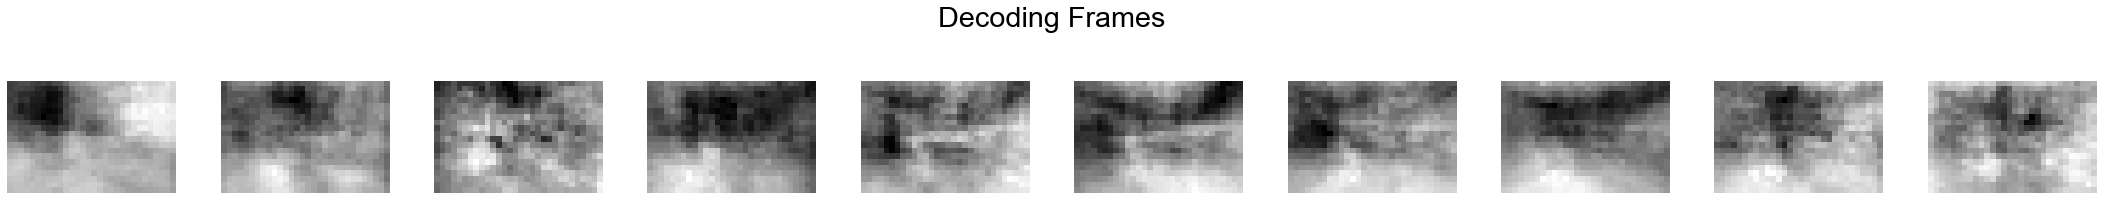

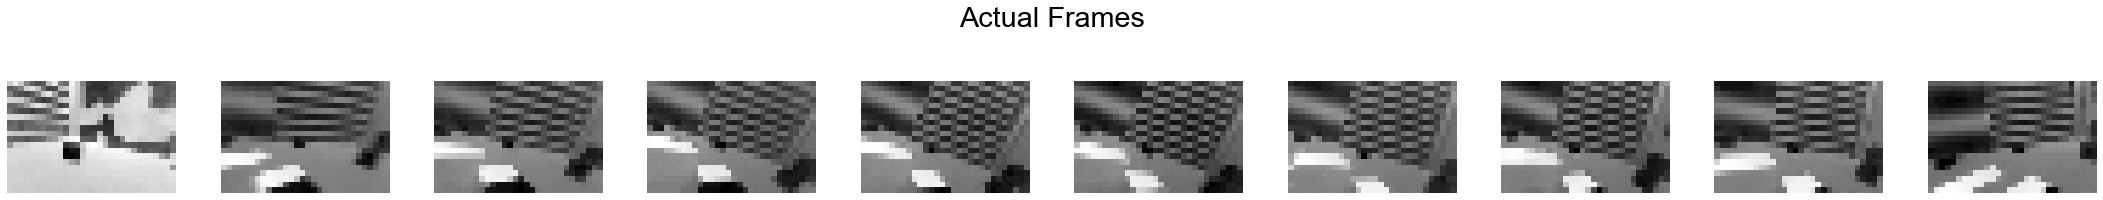

In [336]:
t = 1130 #2000
dt = 10
fig, ax = plt.subplots(1,10,figsize=(30,3))

for n,t in enumerate(np.arange(t,t+dt)):
    ax[n].imshow(pred_test[t,:,:], cmap='gray')
    ax[n].axis('off')
plt.suptitle('Decoding Frames')
plt.tight_layout()
# fig.savefig(FigPath/'Decoding_Frame.png',facecolor='white', transparent=True)

fig2, ax2 = plt.subplots(1,10,figsize=(30,3))
for n,t in enumerate(np.arange(t,t+dt)):
    ax2[n].imshow(test_vid[t,:,:], cmap='gray')
    ax2[n].axis('off')
plt.suptitle('Actual Frames')
plt.tight_layout()
# fig2.savefig(FigPath/'Decoding_Actual_Frame.png',facecolor='white', transparent=True)

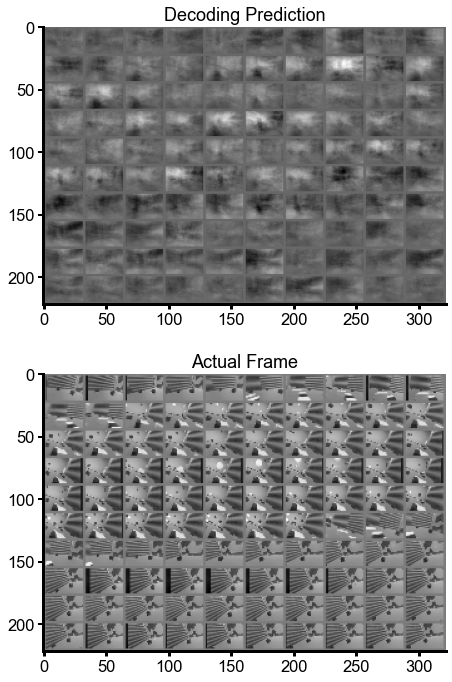

In [332]:
t = 1030 #2000
dt = 100
im_grid = torchvision.utils.make_grid(torch.from_numpy(pred_test[t:t+dt,np.newaxis,:,:]),nrow=10,normalize=False)[0]
im_grid2 = torchvision.utils.make_grid(torch.from_numpy(test_vid[t:t+dt,np.newaxis,:,:]),nrow=10,normalize=False)[0]
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].imshow(im_grid, cmap='gray')#.permute(1,2,0))
axs[0].set_title('Decoding Prediction')
axs[1].imshow(im_grid2, cmap='gray')#.permute(1,2,0))
axs[1].set_title('Actual Frame')
plt.tight_layout()
# fig.savefig(FigPath/'DecodedMontage_{}.png'.format(model_type),bbox_inches='tight',transparent=False, facecolor='w')

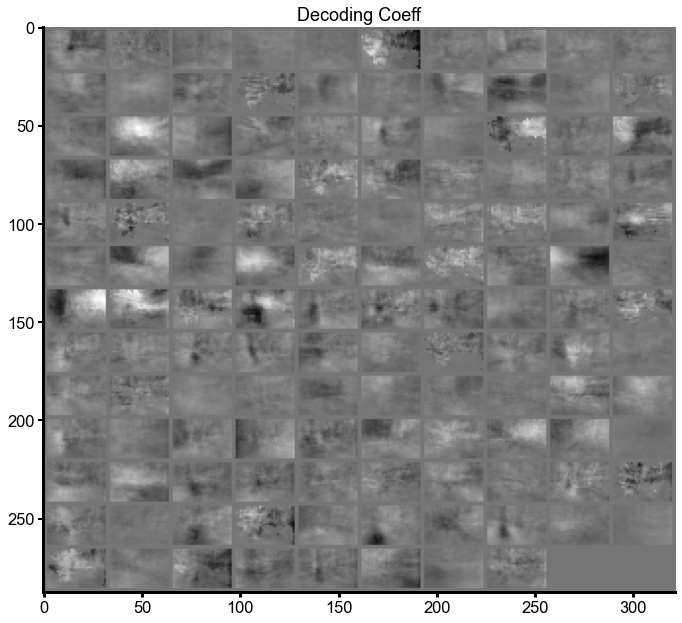

In [328]:
im_grid = torchvision.utils.make_grid(torch.from_numpy(model_coeff[:,np.newaxis]),nrow=10,normalize=False)[0]
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(im_grid, cmap='gray')#.permute(1,2,0))
axs.set_title('Decoding Coeff')
plt.tight_layout()
# fig.savefig(FigPath/'DecodingWeights_{}.png'.format(model_type),bbox_inches='tight',transparent=False, facecolor='w')

In [329]:
sf = 2
pred_test_norm = normimgs(pred_test)
pred_test_up = np.zeros((pred_test.shape[0],sf*pred_test.shape[1],sf*pred_test.shape[2]))
test_vid_norm = normimgs(test_vid)
test_vid_up = np.zeros((test_vid.shape[0],sf*test_vid.shape[1],sf*test_vid.shape[2]))
pred_train_norm = normimgs(pred_train)
pred_train_up = np.zeros((pred_train.shape[0],sf*pred_train.shape[1],sf*pred_train.shape[2]))
train_vid_norm = normimgs(train_vid)
train_vid_up = np.zeros((train_vid.shape[0],sf*train_vid.shape[1],sf*train_vid.shape[2]))
for n in range(pred_test.shape[0]):
    pred_test_up[n] = cv2.resize(pred_test_norm[n],(sf*pred_test.shape[2],sf*pred_test.shape[1]))
    test_vid_up[n] = cv2.resize(test_vid_norm[n],(sf*test_vid.shape[2],sf*test_vid.shape[1]))
    pred_train_up[n] = cv2.resize(pred_train_norm[n],(sf*pred_train.shape[2],sf*pred_train.shape[1]))
    train_vid_up[n] = cv2.resize(train_vid_norm[n],(sf*train_vid.shape[2],sf*train_vid.shape[1]))

cond = 'test'
if cond == 'train':
    tot_samps = np.stack((pred_train_up, train_vid_up))
else:
    tot_samps = np.stack((pred_test_up, test_vid_up))
tot_samps.shape

(2, 8931, 40, 60)

In [ ]:
# # Example Frames Video
# t = 0
# dt = pred_test.shape[0]
# # comb = np.concatenate((normimgs(pred_test),normimgs(test_vid)),axis=2)
# comb = np.concatenate((pred_test_up,test_vid_up),axis=2).astype(np.uint8)
# # comb = (comb - np.min(comb,axis=(-1,-2))[:,np.newaxis,np.newaxis])/(np.max(comb,axis=(-1,-2))-np.min(comb,axis=(-1,-2)))[:,np.newaxis,np.newaxis]
# # comb = (comb*255).astype(np.uint8)

# FPS = 10
# out = cv2.VideoWriter(os.path.join(FigPath,'Frames_ExVid.avi'), cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), FPS, (comb.shape[-1], comb.shape[-2]),0)
            
# for fm in tqdm(range(comb.shape[0])):
#     out.write(comb[fm])
# out.release()

In [ ]:
# ###### Grab data of longest continuous sequence ######
# def func1(a,b):
#     # "Enclose" mask with sentients to catch shifts later on
#     mask = np.r_[False,a,False]

#     # Get the shifting indices
#     idx = np.flatnonzero(mask[1:] != mask[:-1])

#     s0,s1 = idx[::2], idx[1::2]
#     idx_b = np.r_[0,(s1-s0).cumsum()]
#     out = []
#     for (i,j,k,l) in zip(s0,s1-1,idx_b[:-1],idx_b[1:]):
#         out.append(((i, j), b[k:l]))
#     return out

# train_idxs,test_idxs = train_test_split(good_idxs,train_size=.6,random_state=0)

# out = func1(test_idxs,np.arange(test_idxs.shape[0]))

# max_seqn = 0
# for n in range(len(out)):
#     if len(out[n][1]) > max_seqn:
#         max_seq = np.arange(out[n][0][0],out[n][0][1])
#         max_seqn = len(out[n][1])

In [ ]:
win_size = 3
tot_samps2 = uniform_filter1d(tot_samps,win_size,axis=1)

In [ ]:
t = 500
dt = 100
plt.plot(tot_samps2[0,t:t+dt,5,10])
plt.plot(tot_samps[1,t:t+dt,5,10])
plt.plot(tot_samps2[1,t:t+dt,5,10])
plt.legend(['Pred','Actual','Actual_smoothed'])

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from matplotlib import colors
def init():
    for n in range(2):
        axs[n].axis('off')
    plt.tight_layout()

def update(t):
    for n in range(2):
        ims[n].set_data(tot_samps2[n,t])
    plt.draw()

In [ ]:
t = 0# max_seq[0]
lat_dims = 2
x,y = [],[]
fig, axs = plt.subplots(1,2,figsize=(8,4))   #8,16,figsize=(50,30)  
axs = axs.flatten()
ims = []
titles = ['Pred','Actual']
for n in range(2):
    ims.append(axs[n].imshow(tot_samps2[n,t],cmap='gray',norm=colors.Normalize()))
    axs[n].axis('off')
    axs[n].set_title('{}'.format(titles[n]))
plt.tight_layout()
# fig.savefig(os.path.join(FigurePath,'testimg.png'))

In [ ]:
# writervideo = PillowWriter(fps=60)  
ani = FuncAnimation(fig, update, tqdm(range(tot_samps2.shape[1])), init_func=init)  #range(tot_samps.shape[1])
plt.show()
vpath = check_path(FigPath,'version_{:d}'.format(0))
vname =  'DecodedVideo_{}_upsampled{:d}_smoothed{:d}_{}.mp4'.format(model_type,sf, win_size,cond)
writervideo = FFMpegWriter(fps=10) 
ani.save(os.path.join(vpath,vname), writer=writervideo)
print('DONE!!!')

In [ ]:
train_scores = train_scores.reshape((train_vid.shape[-2],train_vid.shape[-1]))
test_scores = test_scores.reshape((test_vid.shape[-2],test_vid.shape[-1]))
fig, axs = plt.subplots(2,1,figsize=(10,10))
im1 = axs[0].imshow(train_scores, vmin=0, vmax=.55)
axs[0].set_title('Train Correlation Map')
add_colorbar(im1)
im2 = axs[1].imshow(test_scores, vmin=0, vmax=.55)
axs[1].set_title('Test Correlation Map')
add_colorbar(im2)
plt.tight_layout()
# fig.savefig(FigPath/'DecodingScores_{}.png'.format(model_type),bbox_inches='tight',transparent=False, facecolor='w')

In [ ]:
t = 1040
dt = 20
comb = np.concatenate((np.concatenate((pred_test[t:t+dt,:,:], test_vid[t:t+dt,:,:]),axis=1)),axis=1)
fig, ax = plt.subplots(1,figsize=(25,20))
ax.imshow(comb)

Decoding wieghts of visual vs, decoding weights of movement and dot product overlap. 

# Pytorch

In [ ]:
# train_roll = train_roll/np.max(train_roll)
# train_roll -=train_roll[0]
# train_pitch = train_pitch/np.max(train_pitch)
# train_pitch -=train_pitch[0]
# test_roll = test_roll/np.max(test_roll)
# test_roll -=test_roll[0]
# test_pitch = test_pitch/np.max(test_pitch)
# test_pitch -=test_pitch[0]

# Y_train = torch.from_numpy(np.stack((train_roll, train_pitch),axis=1)).float()
# Y_test  = torch.from_numpy(np.stack((test_roll, test_pitch),axis=1)).float()

Y_train = torch.from_numpy(train_roll[:,np.newaxis]).float() #train_vid.reshape(train_vid.shape[0],-1)).float()#[:,10:11] # np.stack((train_roll, train_pitch),axis=1) # 
Y_test = torch.from_numpy(test_roll[:,np.newaxis]).float() #test_vid.reshape(test_vid.shape[0],-1)).float()#[:,10:11] # np.stack((test_roll, test_pitch),axis=1) # 

In [ ]:
class DecodingDataset(Dataset):
    def __init__(self, data, output, N_fm, transform=None):
        
        self.data = data
        self.output = output
        self.transform = transform
        self.N_fm = N_fm

    def __len__(self):
        return(self.data.shape[0])
    
    def __getitem__(self,idx):
        if idx < self.N_fm:
            idx = self.N_fm
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = torch.from_numpy(self.data[idx-self.N_fm:idx]).float()
        gt = torch.from_numpy(self.output[idx-self.N_fm:idx,:]).float()
        return sample.view(-1), gt.view(-1)
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
N_fm=1
batch_size = 1024
in_neurons = train_nsp.shape[1]*N_fm
out_neurons = 2048
out_dims = Y_train.shape[-1]*N_fm
NEpochs = 500
# train_dataset = DecodingDataset(train_nsp, np.stack((train_roll, train_pitch),axis=1), N_fm=N_fm)
# test_dataset = DecodingDataset(test_nsp, np.stack((test_roll, test_pitch),axis=1), N_fm=N_fm)
train_dataset = TensorDataset(torch.from_numpy(train_nsp).float(),Y_train)
test_dataset  = TensorDataset(torch.from_numpy(test_nsp).float(),Y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)


In [ ]:
model = nn.Sequential(nn.Linear(in_neurons,out_neurons),
                      nn.ReLU(),
                      nn.Linear(out_neurons,out_neurons),
                      nn.ReLU(),
                      nn.Linear(out_neurons,out_dims)).to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=.0001)
criteria = nn.MSELoss()
early_stopping = EarlyStopping(path=save_dir/'checkpoint.pt')

In [ ]:
tot_loss = []
test_tot_loss = []
for epoch in tqdm(range(NEpochs)):
    epoch_loss = []
    for batch, y in train_dataloader:
        pred = model(batch.to(device))
        loss = criteria(pred.to(device),y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    tot_loss.append(np.mean(epoch_loss))
    
    with torch.no_grad():
        test_epoch_loss = []
        for batch, y in test_dataloader:
            pred = model(batch.to(device))
            loss = criteria(pred.to(device),y.to(device))
            test_epoch_loss.append(loss.item())
        test_tot_loss.append(np.mean(test_epoch_loss))
    early_stopping(np.mean(test_epoch_loss), model)
    if early_stopping.early_stop == True:
        print('Stopped Early!')
        break
    print('Epoch:', epoch, 'Epoch_Loss_Avg: ', np.mean(epoch_loss), 'Test_Epoch_Loss_Avg: ', np.mean(test_epoch_loss))

In [ ]:
wind = np.arange(0,1000)
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(Y_train[wind,0],'b-', label='roll')
ax[0].plot(pred[wind,0].cpu().detach(),'r-', label='pred_roll')
ax[1].plot(Y_train[wind,1],'b-', label='pitch')
ax[1].plot(pred[wind,1].cpu().detach(),'r-', label='pred_pitch')
ax[0].legend()
ax[1].legend()

In [ ]:
with torch.no_grad():
    predt = []
    for batch, y in test_dataloader:
        pred = model(batch.to(device))
        predt.append(pred.cpu().numpy())
    predt = np.concatenate(predt,axis=0)

In [ ]:
wind = np.arange(0,1000)
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(Y_test[wind,0],'b-', label='roll')
ax[0].plot(predt[wind,0],'r-', label='pred_roll')
ax[1].plot(Y_test[wind,1],'b-', label='pitch')
ax[1].plot(predt[wind,1],'r-', label='pred_pitch')